In [1]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# --- MOUNT DRIVE ---
from google.colab import drive
drive.mount('/content/drive')

# --- SETUP PATH ---
PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils import config

# --- SETUP OUTPUT DIRECTORY ---
OUTPUT_DIR = config.MODELS_DIR / "advanced" / "NV"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Setup Complete. Artifacts will be saved to: {OUTPUT_DIR}")

Mounted at /content/drive
✅ Setup Complete. Artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/advanced/NV


In [2]:
# 2. Load Data & Define Features (NO VEGAS)
print("Loading Data...")
features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')

TARGET = 'home_win'
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit',
    'spread_line', 'total_line' # <--- PURE FOOTBALL ONLY
]
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

Loading Data...


In [3]:
# 3. Split
TEST_SEASON = 2023
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

In [4]:
# 4. Scale (CRITICAL for Neural Networks)
print("Scaling Data...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Scaling Data...


In [5]:
# 5. Train Neural Network
print(f"{'-'*30}\nTraining Neural Network (NV)...")

# MLP Parameters
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32), # Two layers: 64 neurons -> 32 neurons
    activation='relu',           # Standard activation logic
    solver='adam',               # The best optimizer for large datasets
    alpha=0.001,                 # Regularization (prevents memorization)
    learning_rate_init=0.001,    # How fast it learns
    max_iter=500,                # Give it time to converge
    random_state=42,
    early_stopping=True,         # Stop if it stops improving (saves time)
    validation_fraction=0.1      # Use 10% of training data to check progress
)

mlp_model.fit(X_train_scaled, y_train)
print("✅ Training Complete.")

------------------------------
Training Neural Network (NV)...
✅ Training Complete.


------------------------------
Evaluation Results...
🧠 Neural Network NV Accuracy: 59.19%


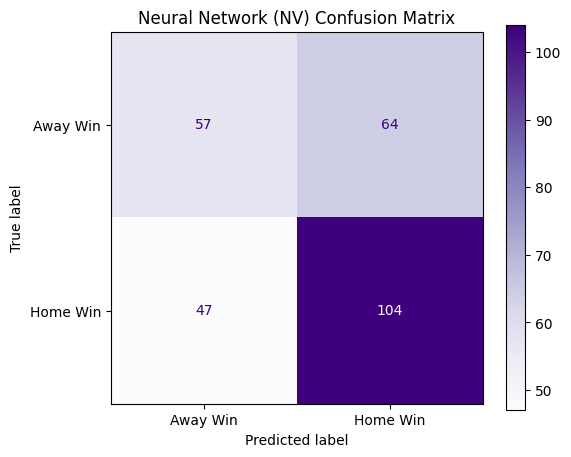

✅ Saved Neural Net model to /content/drive/MyDrive/NFL_Prediction_System/models/advanced/NV


In [6]:
# 6. Evaluate
print(f"{'-'*30}\nEvaluation Results...")
y_pred = mlp_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"🧠 Neural Network NV Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Away Win', 'Home Win'], cmap='Purples', ax=ax)
plt.title("Neural Network (NV) Confusion Matrix")
plt.show()

# Save
with open(OUTPUT_DIR / "nv_neural_net.pkl", 'wb') as f:
    pickle.dump(mlp_model, f)
print(f"✅ Saved Neural Net model to {OUTPUT_DIR}")